In [121]:
if (!requireNamespace("BiocManager", quietly = TRUE))
install.packages("BiocManager")
BiocManager::install()

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.21 (BiocManager 1.30.25), R 4.5.0 (2025-04-11)

Old packages: 'Seurat', 'lattice', 'mgcv', 'scales'



In [122]:
BiocManager::install(c('BiocGenerics', 'DelayedArray', 'DelayedMatrixStats',
                       'limma', 'lme4', 'S4Vectors', 'SingleCellExperiment',
                       'SummarizedExperiment', 'batchelor', 'HDF5Array',
                       'terra', 'ggrastr'))

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.21 (BiocManager 1.30.25), R 4.5.0 (2025-04-11)

Warning message:
"package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'BiocGenerics' 'DelayedArray'
  'DelayedMatrixStats' 'limma' 'lme4' 'S4Vectors' 'SingleCellExperiment'
  'SummarizedExperiment' 'batchelor' 'HDF5Array' 'terra' 'ggrastr'"
Old packages: 'Seurat', 'lattice', 'mgcv', 'scales'



In [123]:
install.packages("devtools")
devtools::install_github('cole-trapnell-lab/monocle3')


The downloaded binary packages are in
	/var/folders/wl/jrkngsm57b944tj7rtjg12000000gn/T//RtmpUUbfSa/downloaded_packages


Using GitHub PAT from the git credential store.

Skipping install of 'monocle3' from a github remote, the SHA1 (98402ed0) has not changed since last install.
  Use `force = TRUE` to force installation



In [124]:
if (!requireNamespace("SeuratWrappers", quietly = TRUE)) {
  remotes::install_github("satijalab/seurat-wrappers")
}

In [125]:
library(Seurat)
library(ggplot2)
library(monocle3)
library(SeuratWrappers)

### Load the data

In [126]:
seu <- readRDS("data/processed/AMC_subset_annotated.rds")

In [127]:
unique(seu$celltype)

[1] Chromaffin cells              Sympathoblasts               
[3] Prolifertating sympathoblasts SCPs                         
4 Levels: Prolifertating sympathoblasts Sympathoblasts ... Chromaffin cells

### Conversion to Cell Data Set

In [128]:
# Convert Seurat to CellDataSet
cds <- as.cell_data_set(seu)

# Transfer the UMAP coordinates from Seurat to Monocle3
reducedDim(cds, "UMAP") <- seu@reductions$umap@cell.embeddings

Warning message:
"Monocle 3 trajectories require cluster partitions, which Seurat does not calculate. Please run 'cluster_cells' on your cell_data_set object"


In [129]:
# Transfer clusters from Seurat
seurat_clusters <- seu$seurat_clusters

# Set clusters and dummy partitions into Monocle3 object
cds@clusters[["UMAP"]] <- list(
  clusters = setNames(as.factor(seurat_clusters), colnames(cds)),
  partitions = setNames(rep("1", length(seurat_clusters)), colnames(cds))  # all in one partition
)

In [130]:
cds <- estimate_size_factors(cds)

In [131]:
colData(cds)

DataFrame with 2118 rows and 29 columns
                                  orig.ident nCount_RNA nFeature_RNA
                                 <character>  <numeric>    <integer>
AAACGCTGTATTCCGA-1_1               week8_001       5589         2236
AAAGGATTCTAGCATG-1_1               week8_001       4952         2206
AAATGGAGTTCTAACG-1_1               week8_001       5552         2314
AACAAGAAGGCCTGCT-1_1               week8_001       6350         2413
AACCAACAGTATTGCC-1_1               week8_001       8483         2894
...                                      ...        ...          ...
TTGTGTTAGAGCGACT-1_13 week12_036_extraadre..       3249         1521
TTGTTGTAGACATCCT-1_13 week12_036_extraadre..      20705         4806
TTTACTGGTTTCGGCG-1_13 week12_036_extraadre..       1237          506
TTTCATGTCGCTGACG-1_13 week12_036_extraadre..       1479         1093
TTTGTTGTCTAGATCG-1_13 week12_036_extraadre..      19389         4522
                                      sample      week   sample

## SCP and Chromaffin

In [132]:
# Subset cells from only those two cell types
scp2chromaffin <- cds[, cds@colData$celltype %in% c("SCPs", "Chromaffin cells")]

In [133]:
# Recreate dummy clusters and partitions for the subset
scp2chromaffin@clusters$UMAP <- list(
  clusters = setNames(as.factor(scp2chromaffin@colData$celltype), colnames(scp2chromaffin)),
  partitions = setNames(rep("1", ncol(scp2chromaffin)), colnames(scp2chromaffin))
)

### Learn Graph

In [134]:
# Re-learn and order the trajectory
scp2chromaffin <- learn_graph(scp2chromaffin)

  |======================================================================| 100%


#### Order Cells

In [135]:
scp2chromaffin <- order_cells(scp2chromaffin, root_cells = colnames(scp2chromaffin)[scp2chromaffin@colData$celltype == "SCPs"])

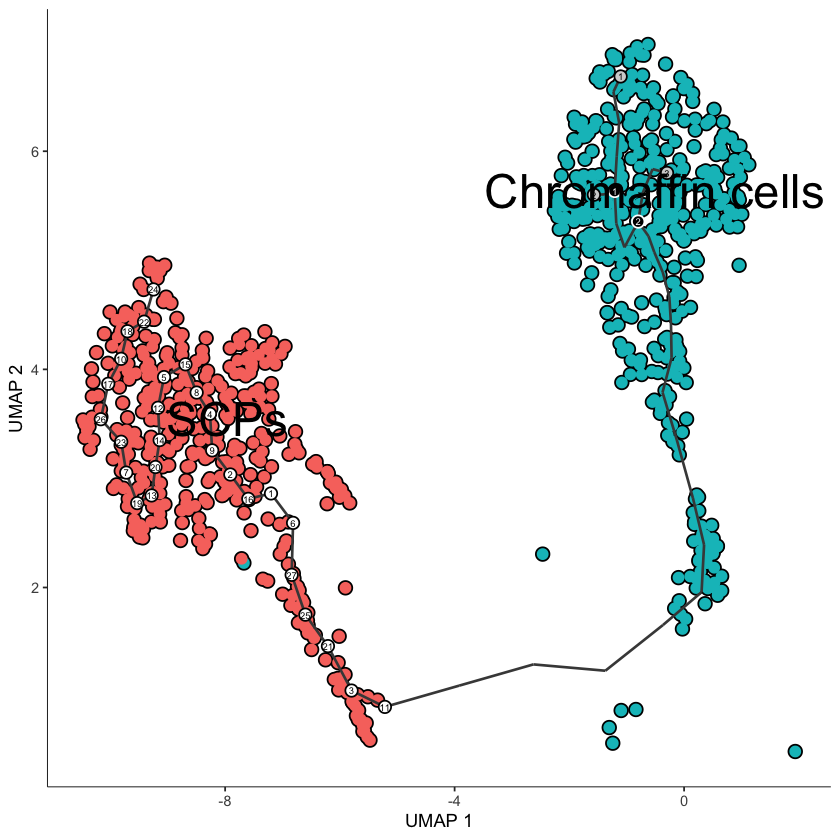

In [136]:
scp2c_cluster <- plot_cells(scp2chromaffin, color_cells_by = "cluster", group_label_size = 10, cell_size = 2)
ggsave("plots/scp_to_chromaffin_cluster.pdf", scp2c_cluster, width = 8, height = 8)
scp2c_cluster

Cells aren't colored in a way that allows them to be grouped.



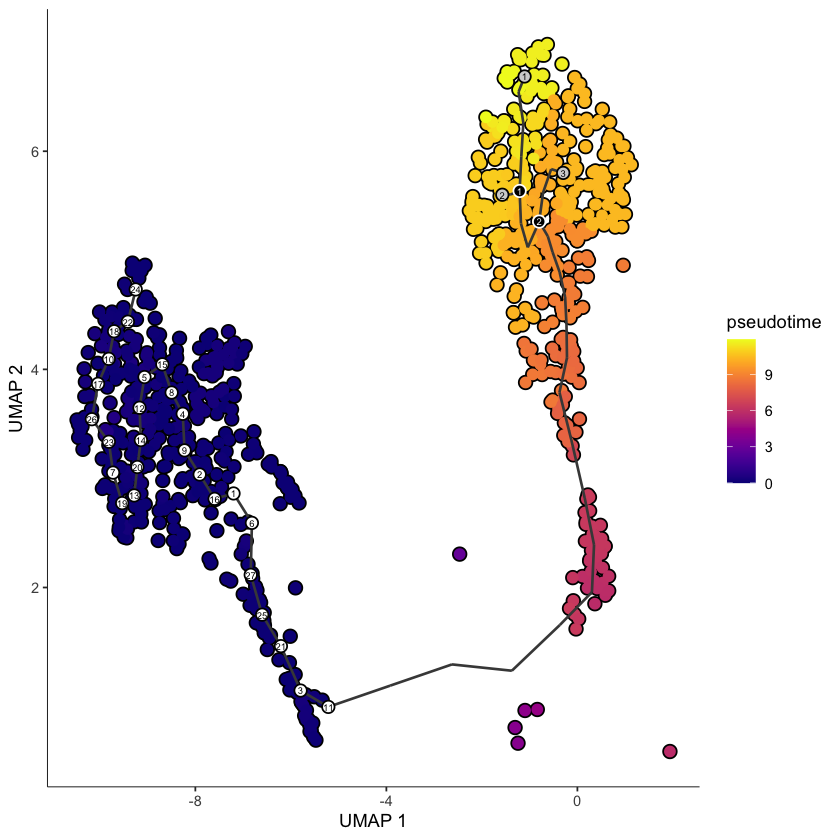

In [137]:
scp2c_psdtime <- plot_cells(scp2chromaffin, color_cells_by = "pseudotime", cell_size = 2)
ggsave("plots/scp_to_chromaffin_pseudotime.pdf", scp2c_cluster, width = 8, height = 8)
scp2c_psdtime

### Heatmap for the significant genes

In [138]:
sum(scp2chromaffin@colData$celltype == "SCPs")

[1] 420

In [139]:
# Perform graph test to find genes correlated with pseudotime
deg <- graph_test(scp2chromaffin, neighbor_graph = "principal_graph", cores = 2)

  |=======================================================| 100%, Elapsed 00:02


In [140]:
deg

,status,p_value,morans_test_statistic,morans_I,q_value
,<chr>,<lgl>,<lgl>,<lgl>,<dbl>
HBM,FAIL,NA,NA,NA,1
AHSP,FAIL,NA,NA,NA,1
HBB,FAIL,NA,NA,NA,1
CHGA,FAIL,NA,NA,NA,1
STMN2,FAIL,NA,NA,NA,1
CHGB,FAIL,NA,NA,NA,1
C1QB,FAIL,NA,NA,NA,1
C1QA,FAIL,NA,NA,NA,1
C1QC,FAIL,NA,NA,NA,1


In [141]:
# Filter DEGs by adjusted p-value
significant_genes <- subset(scp2chromaffin_deg, q_value < 0.1)
gene_names <- rownames(significant_genes)

In [142]:
significant_genes

status,p_value,morans_test_statistic,morans_I,q_value
<chr>,<lgl>,<lgl>,<lgl>,<dbl>


## SCPs and Sympathoblasts

In [143]:
# Subset cells from only those two cell types
scp2sympath <- cds[, cds@colData$celltype %in% c("SCPs", "Sympathoblasts")]

In [144]:
# Recreate dummy clusters and partitions for the subset
scp2sympath@clusters$UMAP <- list(
  clusters = setNames(as.factor(scp2sympath@colData$celltype), colnames(scp2sympath)),
  partitions = setNames(rep("1", ncol(scp2sympath)), colnames(scp2sympath))
)

### Learn Graph

In [145]:
# Re-learn and order the trajectory
scp2sympath <- learn_graph(scp2sympath)

  |======================================================================| 100%


#### Order Cells

In [146]:
scp2sympath <- order_cells(scp2sympath, root_cells = colnames(scp2sympath)[scp2sympath@colData$celltype == "SCPs"])

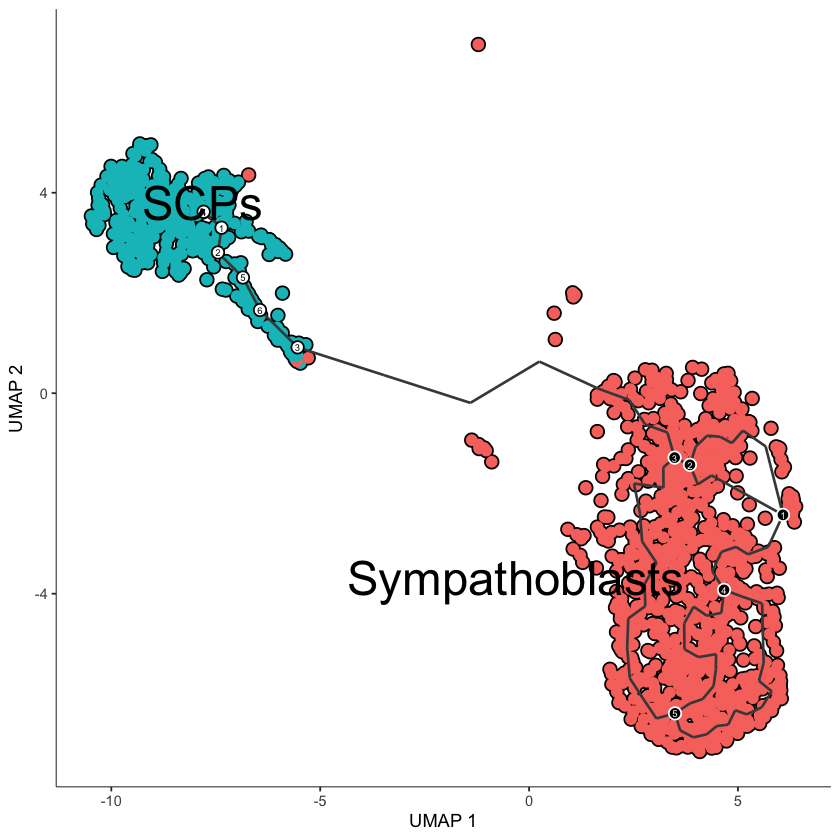

In [147]:
scp2s_cluster <- plot_cells(scp2sympath, color_cells_by = "cluster", group_label_size = 10, cell_size = 2)
ggsave("plots/scp_to_sympathoblasts_cluster.pdf", scp2s_cluster, width = 8, height = 8)
scp2s_cluster

Cells aren't colored in a way that allows them to be grouped.



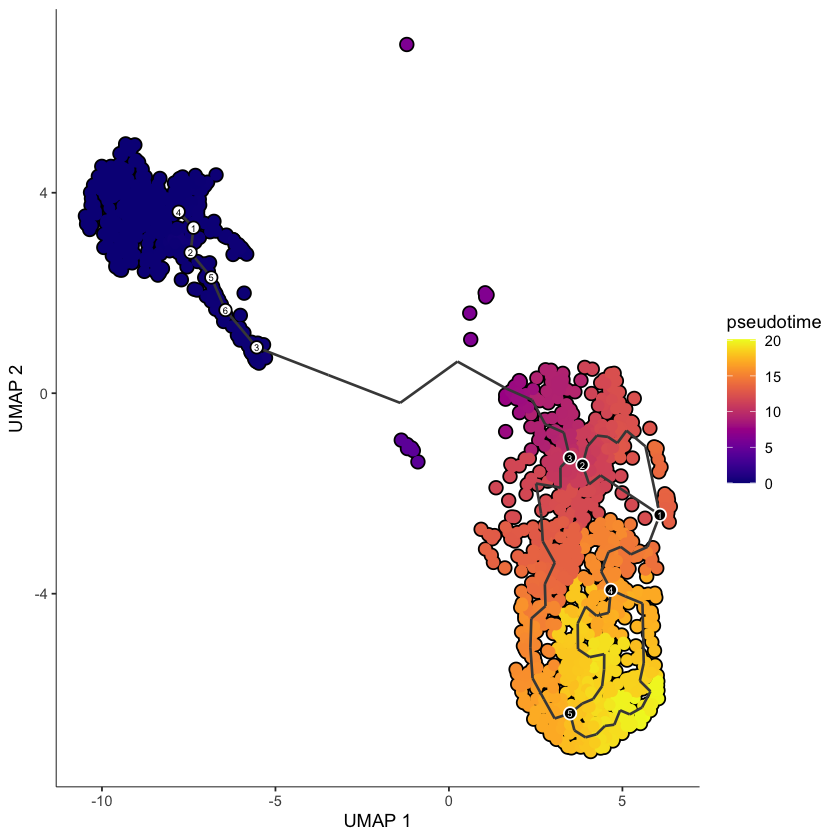

In [148]:
scp2s_psdtime <- plot_cells(scp2sympath, color_cells_by = "pseudotime", cell_size = 2)
ggsave("plots/scp_to_sympathoblast_pseudotime.pdf", scp2s_cluster, width = 8, height = 8)
scp2s_psdtime

## Chromaffin and Sympathoblasts

In [149]:
# Subset cells from only those two cell types
chromaffin2symp <- cds[, cds@colData$celltype %in% c("Chromaffin cells","Sympathoblasts")]

In [150]:
# Recreate dummy clusters and partitions for the subset
chromaffin2symp@clusters$UMAP <- list(
  clusters = setNames(as.factor(chromaffin2symp@colData$celltype), colnames(chromaffin2symp)),
  partitions = setNames(rep("1", ncol(chromaffin2symp)), colnames(chromaffin2symp))
)

### Learn Graph

In [151]:
# Re-learn and order the trajectory
chromaffin2symp <- learn_graph(chromaffin2symp)

  |======================================================================| 100%


#### Order Cells

In [152]:
chromaffin2symp <- order_cells(chromaffin2symp, root_cells = colnames(chromaffin2symp)[chromaffin2symp@colData$celltype == "Chromaffin cells"])

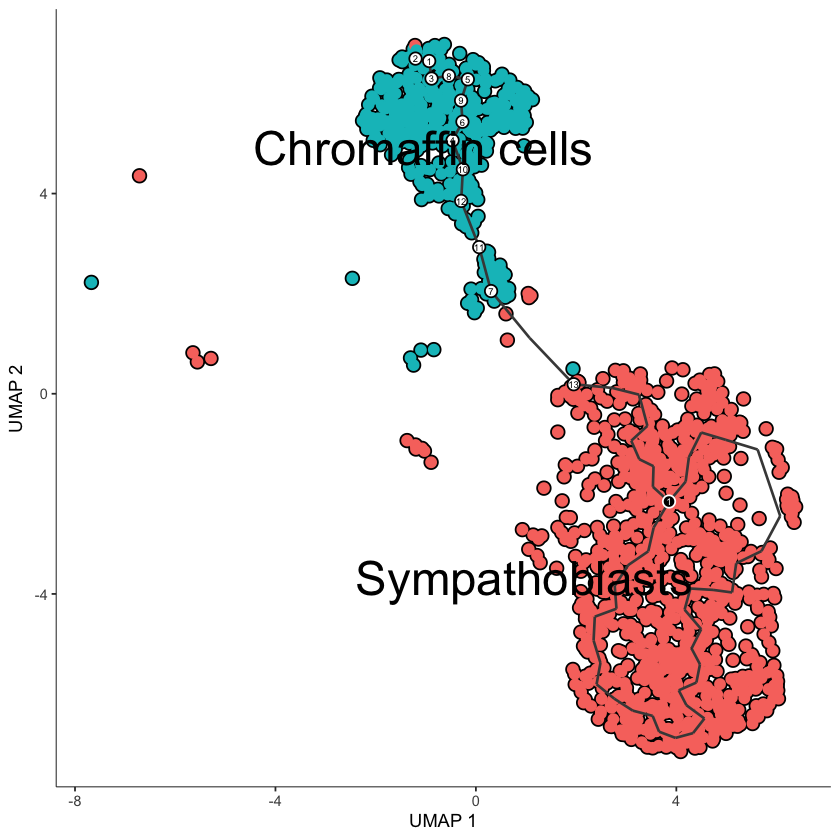

In [153]:
chr2symp_cluster <- plot_cells(chromaffin2symp, color_cells_by = "cluster", group_label_size = 10, cell_size = 2)
ggsave("plots/chromaffin_to_sympathoblast_cluster.pdf", chr2symp_cluster, width = 8, height = 8)
chr2symp_cluster

Cells aren't colored in a way that allows them to be grouped.



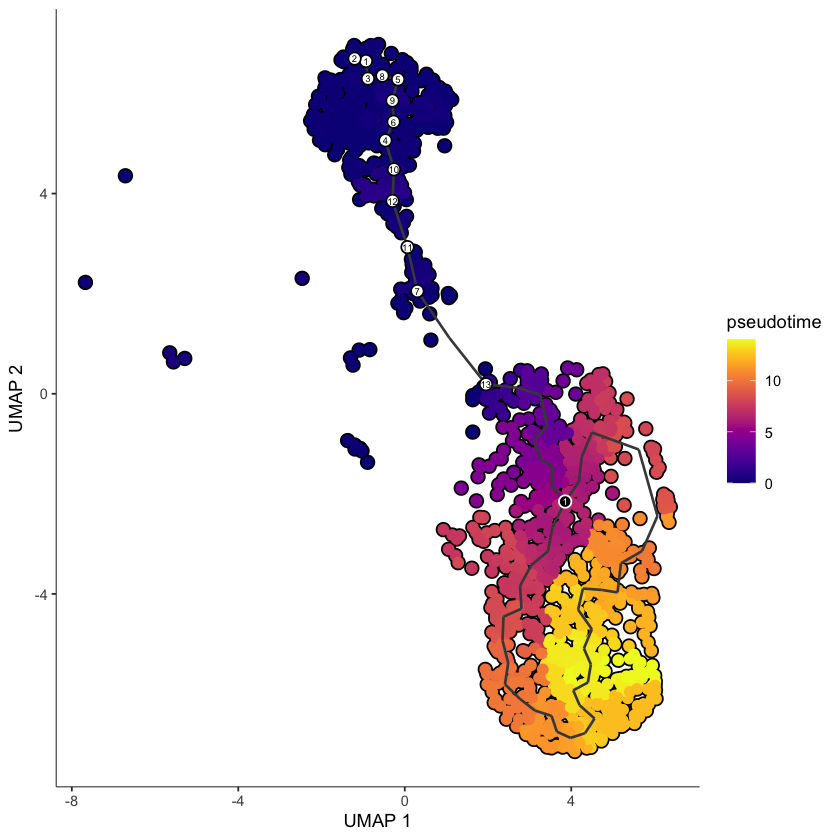

In [154]:
chr2symp_psdtime <- plot_cells(chromaffin2symp, color_cells_by = "pseudotime", cell_size = 2)
ggsave("plots/scp_to_chromaffin_pseudotime.pdf", chr2symp_psdtime, width = 8, height = 8)
chr2symp_psdtime